# Autoencoder: AC Motor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
#from tqdm import tqdm

from sklearn.model_selection import train_test_split

import copy
import torch
from torch import nn, optim
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. 데이터 불러오기

In [3]:
df = pd.read_csv('../dataset/vibration_10k.csv')
df.head()

,Date,Label_No,Label,Motor,WATT,AMP,AbsMax,AbsMean,P2P,RMS,...,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
0,2020-11-25 14:01:00,0.0,정상,L-CAHU-03R,11.0,22.0,0.054116,0.011482,0.092395,0.014053,...,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
1,2020-11-25 14:05:06,0.0,정상,L-CAHU-03R,11.0,22.0,0.051435,0.011649,0.088863,0.014295,...,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2,2020-11-25 14:06:12,0.0,정상,L-CAHU-03R,11.0,22.0,0.046130,0.012619,0.085221,0.015276,...,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
3,2020-11-25 14:06:24,0.0,정상,L-CAHU-03R,11.0,22.0,0.053497,0.011505,0.093581,0.014059,...,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
4,2020-11-25 14:07:03,0.0,정상,L-PAHU-02S,37.0,71.1,0.073671,0.014504,0.123645,0.017763,...,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


In [4]:
df.shape

(10000, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      10000 non-null  object 
 1   Label_No  10000 non-null  float64
 2   Label     10000 non-null  object 
 3   Motor     10000 non-null  object 
 4   WATT      10000 non-null  float64
 5   AMP       10000 non-null  float64
 6   AbsMax    9988 non-null   float64
 7   AbsMean   10000 non-null  float64
 8   P2P       10000 non-null  float64
 9   RMS       10000 non-null  float64
 10  Skewness  10000 non-null  float64
 11  Kurtosis  10000 non-null  float64
 12  Crest     10000 non-null  float64
 13  Shape     10000 non-null  float64
 14  Impulse   10000 non-null  float64
 15  1x        10000 non-null  float64
 16  2x        10000 non-null  float64
 17  3x        10000 non-null  float64
 18  4x        10000 non-null  float64
 19  1xB       10000 non-null  float64
 20  2xB       10000 non-null  flo

## 2. 데이터 탐색

In [6]:
df['Label'].value_counts()

Label
정상        4612
벨트느슨함     1654
축정렬불량     1337
베어링불량     1243
회전체불평형    1154
Name: count, dtype: int64

### 2.1 DateTime Index 지정

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('Date')
df.head()

,Label_No,Label,Motor,WATT,AMP,AbsMax,AbsMean,P2P,RMS,Skewness,...,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-25 14:01:00,0.0,정상,L-CAHU-03R,11.0,22.0,0.054116,0.011482,0.092395,0.014053,-0.142563,...,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
2020-11-25 14:05:06,0.0,정상,L-CAHU-03R,11.0,22.0,0.051435,0.011649,0.088863,0.014295,-0.129078,...,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2020-11-25 14:06:12,0.0,정상,L-CAHU-03R,11.0,22.0,0.046130,0.012619,0.085221,0.015276,-0.144933,...,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
2020-11-25 14:06:24,0.0,정상,L-CAHU-03R,11.0,22.0,0.053497,0.011505,0.093581,0.014059,-0.124687,...,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
2020-11-25 14:07:03,0.0,정상,L-PAHU-02S,37.0,71.1,0.073671,0.014504,0.123645,0.017763,-0.180152,...,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


### 2.2 결측치 확인 및 처리

In [8]:
df.isnull().sum()

Label_No     0
Label        0
Motor        0
WATT         0
AMP          0
AbsMax      12
AbsMean      0
P2P          0
RMS          0
Skewness     0
Kurtosis     0
Crest        0
Shape        0
Impulse      0
1x           0
2x           0
3x           0
4x           0
1xB          0
2xB          0
3xB          0
4xB          0
dtype: int64

In [9]:
df['AbsMax'].fillna(df['AbsMax'].mean(), inplace=True)
df.isnull().sum()

Label_No    0
Label       0
Motor       0
WATT        0
AMP         0
AbsMax      0
AbsMean     0
P2P         0
RMS         0
Skewness    0
Kurtosis    0
Crest       0
Shape       0
Impulse     0
1x          0
2x          0
3x          0
4x          0
1xB         0
2xB         0
3xB         0
4xB         0
dtype: int64

## 3. Feature Engineering

In [10]:
df.drop(['Label', 'Motor', 'WATT', 'AMP'], axis=1, inplace=True)
df.head()

,Label_No,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
Date,,,,,,,,,,,,,,,,,,
2020-11-25 14:01:00,0.0,0.054116,0.011482,0.092395,0.014053,-0.142563,2.606448,6.574603,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
2020-11-25 14:05:06,0.0,0.051435,0.011649,0.088863,0.014295,-0.129078,2.538691,6.216188,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2020-11-25 14:06:12,0.0,0.046130,0.012619,0.085221,0.015276,-0.144933,2.386880,5.578775,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
2020-11-25 14:06:24,0.0,0.053497,0.011505,0.093581,0.014059,-0.124687,2.511421,6.656225,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
2020-11-25 14:07:03,0.0,0.073671,0.014504,0.123645,0.017763,-0.180152,2.612526,6.960855,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


### 3.1 Normal/Anomaly 추출

In [11]:
df['Label_No'].value_counts()

Label_No
0.0    4612
4.0    1654
3.0    1337
1.0    1243
2.0    1154
Name: count, dtype: int64

In [12]:
normal_df = df[df['Label_No'] == 0].drop(labels='Label_No', axis=1)
normal_df.shape

(4612, 17)

In [13]:
anomaly_df = df[df['Label_No'] != 0].drop(labels='Label_No', axis=1)
anomaly_df.shape

(5388, 17)

### 3.2 Train/Test Split 

In [14]:
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state=100)
val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=100)

### 3.3 Time Series 데이터셋 생성

In [15]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [16]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)

test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [17]:
train_dataset[:2]

[tensor([[1.9175e-02],
         [4.8954e-03],
         [3.7621e-02],
         [6.0642e-03],
         [3.4683e-02],
         [2.6413e+00],
         [6.2037e+00],
         [1.2388e+00],
         [3.9169e+00],
         [8.7932e-04],
         [4.1948e-04],
         [1.3186e-04],
         [1.2388e-03],
         [7.8233e-05],
         [1.2019e-03],
         [9.7549e-05],
         [1.7419e-04]]),
 tensor([[3.1657e-02],
         [8.5795e-03],
         [6.3284e-02],
         [1.0297e-02],
         [4.1222e-02],
         [2.3588e+00],
         [6.1459e+00],
         [1.2002e+00],
         [3.6899e+00],
         [2.3027e-03],
         [3.1330e-03],
         [1.6115e-04],
         [7.5946e-04],
         [3.4600e-03],
         [4.6289e-04],
         [6.7497e-05],
         [7.1766e-05]])]

## 4. LSTM Autoencoder Model

### 4.1 Encoder Block

In [18]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 8 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True)

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

### 4.2 Decoder Block

In [19]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=32, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 8 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True)

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True)

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

### 4.3 Encoder-Decoder

In [20]:
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTM_AE, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [21]:
model = LSTM_AE(seq_len, n_features, 8)
model = model.to(device)
print(model)

LSTM_AE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 8, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(8, 8, batch_first=True)
    (rnn2): LSTM(8, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 5. Training

In [22]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in tqdm(range(1, n_epochs + 1)):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [23]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: train loss 3.3220736995491444 val loss 1.9883832165540938
Epoch 2: train loss 1.7248933366309775 val loss 1.6882121880935026
Epoch 3: train loss 1.6929492424375245 val loss 1.6345173199992973
Epoch 4: train loss 1.67285006279696 val loss 1.593961853091454
Epoch 5: train loss 1.6622595810103324 val loss 1.6083631832192835
Epoch 6: train loss 1.6583856216213686 val loss 1.632890816061852
Epoch 7: train loss 1.653932533645052 val loss 1.6365618598255174
Epoch 8: train loss 1.6533569900185934 val loss 1.6201056560610076
Epoch 9: train loss 1.650104760614281 val loss 1.608678298461257
Epoch 10: train loss 1.6507071194486047 val loss 1.606589771726734
Epoch 11: train loss 1.6475888028398764 val loss 1.6040960223963143
Epoch 12: train loss 1.6473198301881096 val loss 1.5939513762555937
Epoch 13: train loss 1.6474790450983814 val loss 1.5971009991982585
Epoch 14: train loss 1.6456018555187144 val loss 1.6142447372942712
Epoch 15: train loss 1.6470202717302862 val loss 1.60963188060287

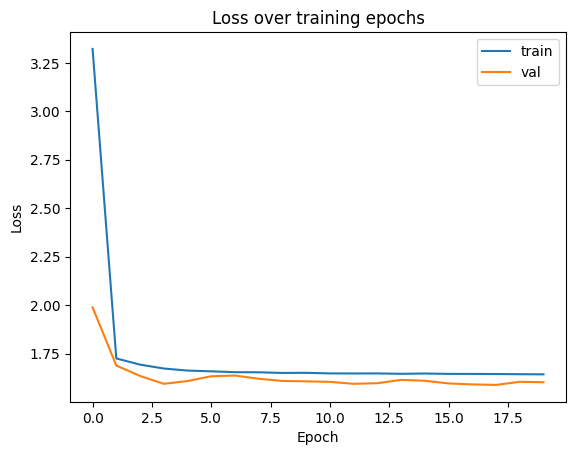

In [24]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

## 6. Model Save & Load

In [26]:
MODEL_PATH = 'lstm_ae_model.pth'

torch.save(model, MODEL_PATH)

In [27]:
model = torch.load(MODEL_PATH)
model = model.to(device)

## 7. Thresholod 탐색
- `L1Loss`: MAE Loss

In [28]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device) # Original Input Data
            seq_pred = model(seq_true) # Reconstruction Data
            loss = criterion(seq_pred, seq_true) # Anomaly Score

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    
    return predictions, losses

In [ ]:
import plotly.express as px

_, losses = predict(model, train_dataset)
fig = px.histogram(losses)
fig.show()

In [30]:
#THRESHOLD = max(losses) # 정상데이터의 max로 지정
THRESHOLD = 5.00 # 분석가가 직접 지정
THRESHOLD

5.0

## 8. Evaluation

### 8.1 Normal 이상치 탐지 적용

In [ ]:
predictions, pred_losses_normal = predict(model, test_normal_dataset)

fig = px.histogram(pred_losses_normal)
fig.show()

In [32]:
correct_normal = sum(l <= THRESHOLD for l in pred_losses_normal)
print(f'Normal Predictions: {correct_normal}/{len(test_normal_dataset)}')

Normal Predictions: 219/229


### 8.2 Anomaly 이상치 탐지 적용

In [35]:
anomaly_dataset = test_anomaly_dataset[:len(test_anomaly_dataset)]

In [ ]:
predictions, pred_losses_anomaly = predict(model, anomaly_dataset)
fig = px.histogram(pred_losses_anomaly)
fig.show()

In [37]:
correct_anomaly = sum(l > THRESHOLD for l in pred_losses_anomaly)
print(f'Anomaly Predictions: {correct_anomaly}/{len(anomaly_dataset)}')

Anomaly Predictions: 1631/5388


## 9. 결과 탐색 시각화

In [40]:
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[0:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();